<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/7.modern_convolutional_neural_networks/7_6_residual_networks_res_net_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [2]:
class Residual(tf.keras.Model):
  def __init__(self, num_channels, use_1x1conv=False, strides=1):
    
    super().__init__()
    self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
    self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
    
    self.conv3 = None
    if use_1x1conv:
      self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()

  def call(self, X):

    Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3 is not None:
            X = self.conv3(X)
    Y += X
    return tf.keras.activations.relu(Y)

In [3]:
blk = Residual(3)
X = tf.random.uniform((4, 6, 6, 3))
Y = blk(X)
Y.shape

TensorShape([4, 6, 6, 3])

In [4]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

TensorShape([4, 3, 3, 6])

In [5]:
b1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [6]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [7]:
b2 = ResnetBlock(64, 2, first_block=True)
b3 = ResnetBlock(128, 2)
b4 = ResnetBlock(256, 2)
b5 = ResnetBlock(512, 2)

In [8]:
def net():
    return tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we
        # created earlier
        ResnetBlock(64, 2, first_block=True),
        ResnetBlock(128, 2),
        ResnetBlock(256, 2),
        ResnetBlock(512, 2),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=10)])

In [9]:
X = tf.random.uniform(shape=(1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv2D output shape:	 (1, 112, 112, 64)
BatchNormalization output shape:	 (1, 112, 112, 64)
Activation output shape:	 (1, 112, 112, 64)
MaxPooling2D output shape:	 (1, 56, 56, 64)
ResnetBlock output shape:	 (1, 56, 56, 64)
ResnetBlock output shape:	 (1, 28, 28, 128)
ResnetBlock output shape:	 (1, 14, 14, 256)
ResnetBlock output shape:	 (1, 7, 7, 512)
GlobalAveragePooling2D output shape:	 (1, 512)
Dense output shape:	 (1, 10)


In [10]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # Divide all numbers by 255 so that all pixel values are between
    # 0 and 1, add a batch dimension at the last. And cast label to int32
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (
        tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    return (
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(
            batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(
            batch_size).map(resize_fn))
    
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
  device_name = device._device_name
  strategy = tf.distribute.OneDeviceStrategy(device_name)
  with strategy.scope():
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    net = net_fn()
    net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[PlotLossesKeras()])
  return net

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if len(tf.config.experimental.list_physical_devices('GPU')) >= i + 1:
        return tf.device(f'/GPU:{i}')
    return tf.device('/CPU:0')

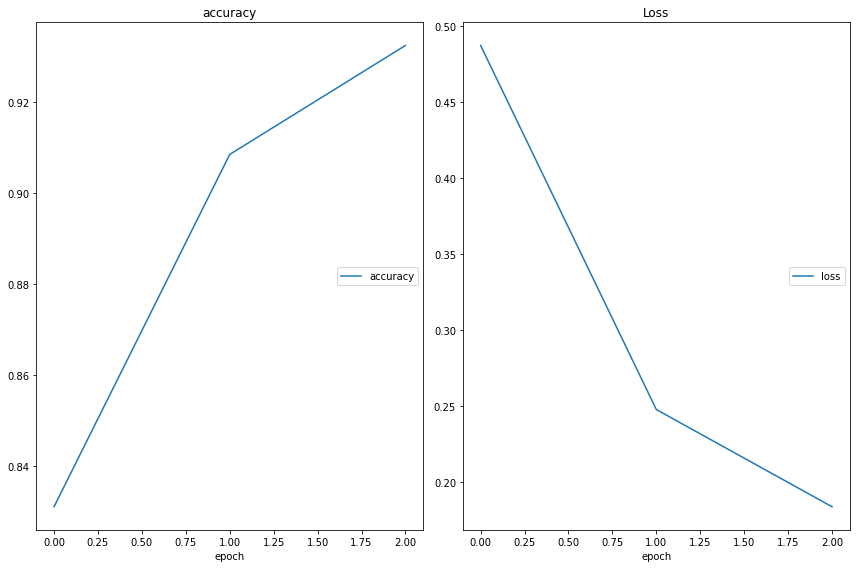

accuracy
	accuracy         	 (min:    0.831, max:    0.932, cur:    0.932)
Loss
	loss             	 (min:    0.184, max:    0.487, cur:    0.184)


In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())